<a href="https://colab.research.google.com/github/YoheiFukuhara/bert_nlp/blob/main/section_4/01_simple_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなファインチューニング
最小限のコードでファインチューニングを実装します。  
事前学習済みのモデルに、何回か追加で訓練を行います。

## ライブラリのインストール
ライブラリTransformersをインストールします。  
https://huggingface.co/transformers/index.html

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 11.9 MB/s 
     |████████████████████████████████| 6.8 MB 38.8 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 46.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## モデルの読み込み
`BertForSequenceClassification`により、事前学習済みのモデルを読み込みます。

In [2]:
from transformers import BertForSequenceClassification

sc_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", return_dict=True)
print(sc_model.state_dict().keys())

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

## 最適化アルゴリズム
今回は、最適化アルゴリズムに`AdamW`を採用します。  
`AdamW`は、オリジナルのAdamの重みの減衰に関する式を変更したものです。  
https://arxiv.org/abs/1711.05101

In [3]:
from transformers import AdamW

optimizer = AdamW(sc_model.parameters(), lr=1e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Tokenizerの設定
`BertTokenizer`により文章を単語に分割し、idに変換します。  
`BertForSequenceClassification`のモデルの訓練時には入力の他にAttention maskを渡す必要があるのですが、`BertTokenizer`によりこちらも得ることができます。

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sentences = ["I love baseball.", "I hate baseball."]
tokenized = tokenizer(sentences, 
                      return_tensors="pt",  # PyTorchのTensorの形で返すらしい
                      padding=True, truncation=True)
print(tokenized)

x = tokenized["input_ids"]
attention_mask = tokenized["attention_mask"]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

{'input_ids': tensor([[ 101, 1045, 2293, 3598, 1012,  102],
        [ 101, 1045, 5223, 3598, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}


## ファインチューニング
事前に学習済みのモデルに対して、追加で訓練を行います。

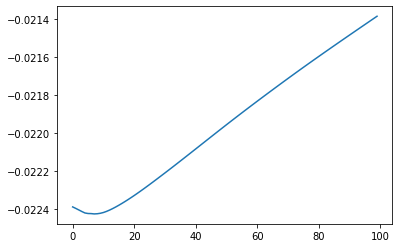

In [5]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

sc_model.train()
t = torch.tensor([1,0])  # 文章の分類

weight_record = []  # 重みを記録

for i in range(100):
    y = sc_model(x, attention_mask=attention_mask)
    loss = F.cross_entropy(y.logits, t)
    loss.backward()
    optimizer.step()

    # 11番目の層から取得
    weight = sc_model.state_dict()["bert.encoder.layer.11.output.dense.weight"][0][0].item()
    weight_record.append(weight)

plt.plot(range(len(weight_record)), weight_record)
plt.show()

追加の訓練により、重みが調整されていく様子が確認できます。